<a href="https://colab.research.google.com/github/PN1019/MobileGameABTesting/blob/main/CookieCatsGameAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Cookie Cats** is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level. It also features singing cats. We're not kidding! Check out this short demo:

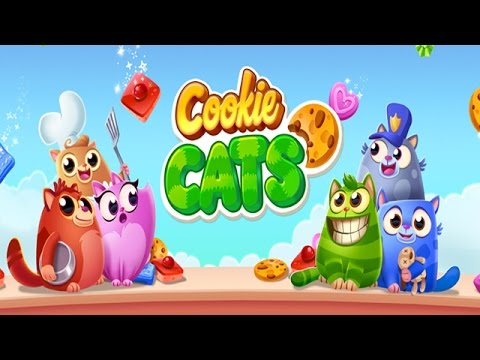

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('LLVD72FuRlw')

As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.


But where should the gates be placed? Initially the first gate was placed at level 30, but in this notebook we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40. In particular, we will look at the impact on player retention. But before we get to that, a key step before undertaking any analysis is understanding the data. So let's load it in and take a look!



In [2]:
# Importing pandas
#import pandas as pd
from google.colab import files
uploaded = files.upload()



Saving cookie_cats_new.csv to cookie_cats_new.csv


In [3]:
import pandas as pd
import io
import matplotlib.pyplot as plt


#df2 = pd.read_csv(io.BytesIO(uploaded['cookie_cats_new.csv']))
df = pd.read_csv('cookie_cats_new.csv')


In [4]:
#check head
df.head()
# Integrity Check
df.info()

# Describe
df.describe()

# Check levels
df.version.unique()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


array(['gate_30', 'gate_40'], dtype=object)

### **EDA OUTPUT**

It appears that we have **90,189** rows populated over 5 columns, and no missing data! Perfect.

Our columns are userid, version, sum_gamerounds, retention_1, and retention_7.
 Only two columns contain numeric variables, userid and sum_gamerounds. Userid reflects unique user ID’s, and sum_gamerounds reflects the number of rounds played by each unique user. 
 Version contains 2 groups, and will be the source of some of our AB groupings. 
 As we see from our EDA output, there are two levels, gate_30 and gate_40. Finally, our last two columns, retention_1 and retention_7 are boolean values, True or False, indicating whether a player is still active after 1 or 7 days.

Like most “free” mobile games, there is an economic element for the craftsmen of the product to generate revenue. 
In this case, there is a forced cool-down period after so many levels, which the player can remove by paying a fee. 
The version column in our dataframe reflects versions with different gates preventing the player’s progress, after 30 levels or after 40, these are recorded as gate_30 and gate_40.

These two versions allow us a fine entry point to AB testing.

**Sanity Check**

Let’s first define the population sizes we’re dealing with to make sure we can proceed with a statistically sound comparison.

In [5]:
# Counting the number of players in each AB group.
A = df.version.groupby(df.version == "gate_30").count()
B = df.version.groupby(df.version == "gate_40").count()
print(A)
print(B)


version
False    45489
True     44700
Name: version, dtype: int64
version
False    44700
True     45489
Name: version, dtype: int64


Of our 90,189 total records, approximately half are using version gate_30 (which we will call Group A) and the other half are using version gate_40 (which we will call version B).

This is great, we can proceed with the analysis.



**How Much Do They Play?**

We want to see how many how long players typically stay with a product. One way to measure the metric in this case, is to examine how many rounds each user plays.

Since we’re using a Pandas DataFrame, we can take the following approach. We’ll use .groupby() to set each user’s experience to a bin, and return a total count. We’ll then plot how many players are active within a set range, showing us the counts of players within the 0-100 range of total rounds played.

Text(0.5, 1.0, 'Number of Game Rounds Players on the First Week')

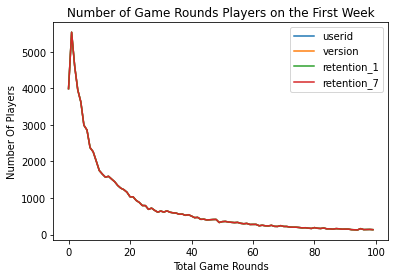

In [6]:
# Counting the number of players for each number of gamerounds 
plot_df = df.groupby("sum_gamerounds").count()

# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_df[:100].plot()
ax.set_xlabel("Total Game Rounds")
ax.set_ylabel("Number Of Players")
ax.set_title("Number of Game Rounds Players on the First Week")

#### **Conclusion:**

It appears that the vast majority of users are playing less than 20 rounds in total, over the recording of this data.

Let’s take the same approach to see if there is much of a difference in the number of games played in our AB versions allotted to each user.



## **Group Distributions: A vs B Total Plays**

This time, we’ll need to explore the data a bit more. We’re also going to switch to an overlayed bar-plot of the distinct AB group distributions.

Since we’ve already identified that the drop off in users occurs in less than 20 sessions, let’s also change our bin distribution to get a more nuanced view of the low end and high end of user activities.




In [7]:
plt.style.use('ggplot')

# Counting the number of players for each number of gamerounds 
Group_A = df[df.version == 'gate_30']
print(Group_A.head())

Group_B = df[df.version == 'gate_40']
print(Group_B.head())
bins = [0,1,10,20,30,40,50,60,70,80,90,100,200,500]
plot_GA = pd.DataFrame(Group_A.groupby(pd.cut(Group_A["sum_gamerounds"], bins=bins)).count())
plot_GB = pd.DataFrame(Group_B.groupby(pd.cut(Group_B["sum_gamerounds"], bins=bins)).count())


    userid  version  sum_gamerounds  retention_1  retention_7
0      116  gate_30               3        False        False
1      337  gate_30              38         True        False
6     1066  gate_30               0        False        False
11    2101  gate_30               0        False        False
13    2179  gate_30              39         True        False
   userid  version  sum_gamerounds  retention_1  retention_7
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True
5     540  gate_40             187         True         True
7    1444  gate_40               2        False        False


Remember, we’re going to overlay our graphs, so take particular notice of one approach that works for our example, where we assign the second graph the parameter ax=ax to allow the overlay of the second distribution.



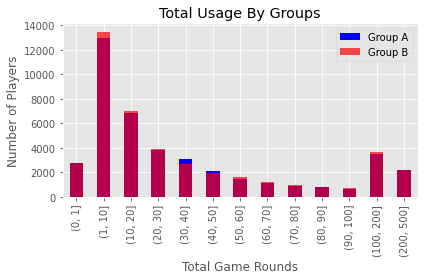

In [8]:
# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_GA[:50].plot(kind = 'bar', y="userid", color = "blue", alpha = 1, 
                       title = 'Total Usage By Groups')
plot_GB[:50].plot(kind = 'bar', y="userid", ax=ax, color = "red", alpha = 0.7 )
ax.set_xlabel("Total Game Rounds")
ax.set_ylabel("Number of Players")
plt.legend(["Group A", "Group B"])
plt.tight_layout()
plt.grid(True)


There doesn’t seem to be a large difference between the two versions overall. However, there does seem to be some slight disparities around the 30-40 marks that may be related to the AB test at hand.




**Overall 1-Day Retention**


What we want is for players to like the game and to get hooked. A common metric in the video gaming industry for how fun and engaging a game is 1-day retention: The percentage of players that comes back and plays the game one day after they have installed it. The higher 1-day retention is, the easier it is to retain players and build a large player base.

As a step, let's look at what 1-day retention is overall.



In [9]:
# Calculate percent of returning users - next day
oneday = df.retention_1.sum()/df.retention_1.count()
print(str(oneday*100)+"%")


44.52095044850259%



**44.52095044850259%**
Return the day following an installation of the product.

Slightly less than half? Ok, just out of curiousity is there any fundamental difference in our two user populations from the start regardless of version impact? This time, let’s do as we did above, but this time group them by version group and see how the numbers pan out.



In [10]:
# Calculating 1-day retention for each AB-group
oneday = df.retention_1.groupby(df.version).sum()/df.retention_1.groupby(df.version).count()
print(oneday)


version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64


It looks like regardless of version, next day returns are essentially the same between our experimental groups.

But, there IS that 0.6% loss in return players randomized to the 40 round gate…could it be significant? Maybe this product will see millions of users and that extra 0.6% could translate into some paying customers and/or ad dollars.

It’s worth investigating.

We can use *Bootstrapping* to test our confidence. Bootstrapping is used in many disciplines, such as in molecular biology to help the analysis of phylogenetics, to re-sample and replace data to and test our statistical confidence in our results.



# **Bootstrapping Means Sampling**

In [11]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
for i in range(500):
    boot_mean = df.retention_1.sample(frac=1, replace=True).groupby(df.version).mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
print(boot_1d)
    


version       gate_30   gate_40
retention_1  0.442167  0.439730
retention_1  0.447035  0.444378
retention_1  0.448682  0.440593
retention_1  0.449460  0.440447
retention_1  0.449435  0.444479
...               ...       ...
retention_1  0.448644  0.442023
retention_1  0.447459  0.445079
retention_1  0.448447  0.442765
retention_1  0.447034  0.444814
retention_1  0.448001  0.448050

[500 rows x 2 columns]


Text(0.5, 0, 'The Average of 1-Day Retention')

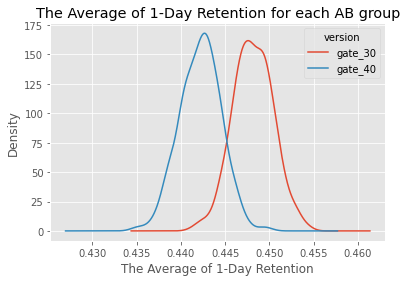

In [12]:
# A Kernel Density Estimate plot of the bootstrap distributions
ax= boot_1d.plot.kde()
ax.set_title("The Average of 1-Day Retention for each AB group")
ax.set_xlabel("The Average of 1-Day Retention")

**Zooming over % Difference**

These two distributions above represent the bootstrap uncertainty over what the underlying 1-day retention could be for the two AB-groups. Let’s zoom in on the difference in 1-day retention.


Text(0.5, 1.0, 'Zooming % Difference')

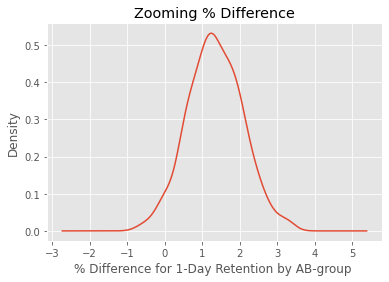

In [13]:
# Populate a new % Difference Column
boot_1d['difference'] = (boot_1d['gate_30'] - boot_1d['gate_40']) /  boot_1d['gate_40'] * 100

# Plot the new Column
ax = boot_1d['difference'].plot.kde()
ax.set_xlabel("% Difference for 1-Day Retention by AB-group ")
ax.set_title("Zooming % Difference")

From this chart, we can see that the most likely % difference is around 1% — 2%, and that most of the distribution is above 0%, in favor of a gate at level 30. But what is the probability that the difference is above 0%?



In [14]:
prob =(boot_1d['difference'] > 0).sum() / len(boot_1d['difference'])
print(str(prob*100)+"%")


96.6%


**Overall 7 Day Retention**

The bootstrap analysis tells us that there is a high probability that 1-day retention is better when the gate is at level 30. However, since players have only been playing the game for one day, it is likely that most players haven't reached level 30 yet. That is, many players won't have been affected by the gate, even if it's as early as level 30.

But after having played for a week, more players should have reached level 40, and therefore it makes sense to also look at 7-day retention. That is: What percentage of the people that installed the game also showed up a week later to play the game again.

Let's start by calculating 7-day retention for the two AB-groups.

In [15]:
# Calculating 7-day retention for both AB-groups
df.groupby('version')['retention_7'].sum() / df.groupby('version')['retention_7'].count()


version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

Like with 1-day retention, we see that 7-day retention is slightly lower (18.2%) when the gate is at level 40 than when the gate is at level 30 (19.0%). This difference is also larger than for 1-day retention, presumably because more players have had time to hit the first gate. But as before, let’s use bootstrap analysis to figure out how certain we should be of the difference between the AB-groups.



In [16]:
boot_7d = []
for i in range(500):
    boot_mean = df.retention_7.sample(frac=1, replace=True).groupby(df.version).mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)
print(boot_7d.head())
# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d['gate_30'] - boot_7d['gate_40']) /  boot_7d['gate_40'] * 100



version       gate_30   gate_40
retention_7  0.187388  0.178608
retention_7  0.188500  0.183803
retention_7  0.187559  0.179757
retention_7  0.190520  0.179706
retention_7  0.187352  0.180296


1.0


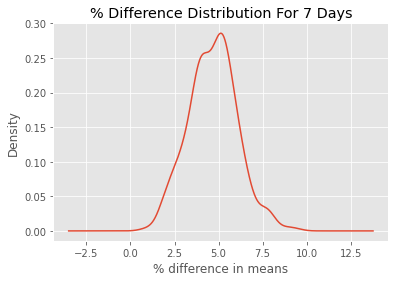

In [18]:
# Plotting the bootstrap % difference
ax = boot_7d['diff'].plot.kde()
ax.set_xlabel("% difference in means")
ax.set_title("% Difference Distribution For 7 Days")
# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob = (boot_7d['diff'] > 0).sum() / len(boot_7d['diff'])

# Pretty printing the probability
print(prob)


## **The Conclusion**

The bootstrap result tells us that there is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40. The conclusion is: If we want to keep retention high — both 1-day and 7-day retention — we should not move the gate from level 30 to level 40. There are, of course, other metrics we could look at, like the number of game rounds played or how much in-game purchases are made by the two AB-groups. But retention is one of the most important metrics. If we don’t retain our player base, it doesn’t matter how much money they spend in-game.

So, why is retention higher when the gate is positioned earlier? One could expect the opposite: The later the obstacle, the longer people are going to engage with the game. But this is not what the data tells us. The theory of hedonic adaptation can give one explanation for this. In short, hedonic adaptation is the tendency for people to get less and less enjoyment out of a fun activity over time if that activity is undertaken continuously. By forcing players to take a break when they reach a gate, their enjoyment of the game is prolonged. But when the gate is moved to level 40, fewer players make it far enough, and they are more likely to quit the game because they simply got bored of it.

***Therefore, it makes sense that we keep gate at Level 30***

